Collaborators:
- **Aristarchos Kaloutsas**
- **Pavlos Ntais**

# **Prerequisites**

In [ ]:
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install nltk
!pip install spacy
!pip install transformers
!pip install langdetect
!pip install seaborn
!pip install torch
!pip install deep-translator
!python -m spacy download en_core_web_sm
!pip install wordcloud


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 21.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# **Libraries**

In [ ]:
# part 1
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns

# langauge detection
from deep_translator import GoogleTranslator
from langdetect import detect

use_drive = True
if (use_drive):
    from google.colab import drive
    drive.mount('/content/drive')

# part 2
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


import spacy
import spacy.cli
from sklearn.feature_extraction.text import CountVectorizer as cvect
from sklearn.feature_extraction.text import TfidfVectorizer as tfvect

try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    import subprocess
    subprocess.run(["python3", "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Preprocessing**

In [ ]:
# modify this to use the folder where the data exists

main_directory = None
if (use_drive):
    main_directory = os.path.join(f"/content/drive/MyDrive/", 'data')
    dataset_path   = '/content/drive/MyDrive/final_df.csv'
else:
    home_directory = os.path.expanduser('~')
    main_directory = os.path.join(home_directory, 'data')
    dataset_path   = 'final_df.csv'

def merge(year):
    folder = os.path.join(main_directory, str(year))

    dfs   = []
    dfs_r = []

    for month_folder in os.listdir(folder):
        month_folder_path = os.path.join(folder, month_folder)

        if not os.path.isdir(month_folder_path):
            continue

        reviews_name = os.path.join(month_folder_path, 'reviews.csv')
        csv_files = [file for file in os.listdir(month_folder_path) if file.endswith('listings.csv')]

        for csv_file in csv_files:
            csv_file_path = os.path.join(month_folder_path, csv_file)

            df_r = pd.read_csv(reviews_name)

            df = pd.read_csv(csv_file_path)

            df['month'] = os.path.basename(os.path.normpath(month_folder_path))

            dfs.append(df)
            dfs_r.append(df_r)


    merged_df = pd.concat(dfs, ignore_index=True)

    df_rev = pd.concat(dfs_r, ignore_index=True)

    merged_df['neighbourhood'] = merged_df['neighbourhood_cleansed']

    if year == 2019:
        filt = [
            "id"
            ,"zipcode"
            ,"transit"
            ,"Bedrooms"
            ,"Beds"
            ,"Review_scores_rating"
            ,"Number_of_reviews"
            ,"Neighbourhood"
            ,"Name"
            ,"Latitude"
            ,"Longitude"
            ,"Last_review"
            ,"Instant_bookable"
            ,"Host_since"
            ,"Host_response_rate"
            ,"Host_identity_verified"
            ,"Host_has_profile_pic"
            ,"First_review"
            ,"Description"
            ,"City"
            ,"cancellation_policy"
            ,"Bed_type"
            ,"Bathrooms"
            ,"Accommodates"
            ,"Amenities"
            ,"Room_type"
            ,"Property_type"
            ,"price"
            ,"Availability_365"
            ,"Minimum_nights"
            ,"month"
            ,"host_id"
        ]
    else:
        filt = [
            "id"
            ,"Bedrooms"
            ,"Beds"
            ,"Review_scores_rating"
            ,"Number_of_reviews"
            ,"Neighbourhood"
            ,"Name"
            ,"Latitude"
            ,"Longitude"
            ,"Last_review"
            ,"Instant_bookable"
            ,"Host_since"
            ,"Host_response_rate"
            ,"Host_identity_verified"
            ,"Host_has_profile_pic"
            ,"First_review"
            ,"Description"
            ,"Bathrooms"
            ,"Accommodates"
            ,"Amenities"
            ,"Room_type"
            ,"Property_type"
            ,"price"
            ,"Availability_365"
            ,"month"
            ,"Minimum_nights"
            ,"host_id"
        ]

    filtr = [s.lower() for s in filt]

    filtered = merged_df[filtr]

    filtNaN =  ['room_type', 'name', 'month', 'price', 'neighbourhood', 'room_type', 'description', 'last_review', 'review_scores_rating', 'host_id']
    if year == 2019:
        filtNaN.extend(['transit'])

    for f in filtNaN:
        filtered = filtered[filtered[f].notnull()]

    if year == 2019:
        filtered['zipcode'] = filtered['zipcode'].str.replace('\s+', '', regex=True)

    filtered["price"] = filtered["price"].replace("[$,]", "", regex=True).astype(float)

    filtered = filtered[filtered['price'] < 10000]

    filtered = filtered[filtered['price'] > 0]

    filtered = filtered[filtered['id'] < 1000000000]

    filtered['last_review'] = pd.to_datetime(filtered['last_review'], errors='coerce')

    int_cols = ['bedrooms', 'beds']
    if year == 2019:
        int_cols.extend(['id', 'zipcode'])

    for col in int_cols:
        filtered[col] = pd.to_numeric(filtered[col], errors='coerce', downcast='integer')

    df_rev = df_rev[df_rev['comments'].notnull()]

    return filtered, df_rev

In [ ]:
# get the dataframes
m2019, r2019 = merge(2019)
m2023, r2023 = merge(2023)

<ipython-input-54-1590ecb15840>:32: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)
<ipython-input-54-1590ecb15840>:32: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)
<ipython-input-54-1590ecb15840>:32: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


We opted to translate comments. This is a common technique because it allows the model to better understand the sentiments, opinions, and feedback from users across different language groups. This can provide more comprehensive insights into user preferences and behaviors.

In [ ]:
from langdetect import detect, LangDetectException
from deep_translator import GoogleTranslator
from requests.exceptions import RequestException
import time

translator = GoogleTranslator(source='auto', target='en')

# Get the list of supported languages
try:
    origin = translator.get_supported_languages(as_dict=True)
except RequestException as e:
    print(f"Failed to fetch supported languages: {e}")
    origin = {}

supported_languages = {value: key for key, value in origin.items()}

def translate_sentence(sentence):
    try:
        detected_lang = detect(sentence)
    except LangDetectException:
        return sentence

    if detected_lang not in supported_languages:
        return sentence

    if detected_lang == 'en':
        return sentence

    translator = GoogleTranslator(source=detected_lang, target='en')

    # Retry logic for the translation request
    retries = 10
    for attempt in range(retries):
        try:
            translated_text = translator.translate(sentence)
            if len(translated_text) == 0:
                return sentence
            return translated_text
        except RequestException as e:
            print(f"Translation attempt {attempt + 1} failed: {e}")
            if attempt < retries - 1:
                sleep_time = 2 ** attempt  # Exponential backoff
                print(f"Retrying in {sleep_time} seconds...")
                time.sleep(sleep_time)
            else:
                return sentence

### **Preprocessing**
In preprocessing, we follow these (basic) steps:
- Remove excess tabs and white spaces.
- Convert the tweet to lowercase.
- Remove numbers and special characters.
- Remove HTML tags.
- Remove hashtags.
- Remove mentions.
- Remove URLs.
- Remove emojis.
- Apply basic preprocessing steps.
- Translate the tweet to english.
- Lemmatize the tweet.
- Remove stop words (including custom my_stop_words).
- Remove excess tabs and white spaces again before returning the cleaned tweet.

In [ ]:
number_of_tweets = 0

def basic_preproc(tweet_str):
    # remove excess tabs & white spaces
    tweet_str = re.sub(r'\s+', ' ', tweet_str).strip()

    # convert to lowercase for generalization
    tweet_str = tweet_str.lower()

    # remove numbers & special characters
    tweet_str = re.sub(r'[0-9]|\W', ' ', tweet_str)

    return tweet_str

my_stop_words = {
    "kitchen", "sofa", "apartment", "house", "room", "bathroom", "bedroom", "living",
    "space", "place", "stay", "staying", "night", "host", "guest", "check", "in", "out",
    "time", "times", "location", "area", "city", "bed", "beds", "couch", "chairs", "table",
    "desk", "furniture", "design", "rating", "experience", "visit", "visited", "trip",
    "rate", "instructions", "guide", "policy", "policies", "procedure", "procedures",
    "travelling", "travel", "traveler", "holiday", "vacation", "business", "work", "conference",
    "convenient", "amenity", "facilities", "facility", "provided", "provide", "provision" }

def clean_tweet(tweet_str, translate = True):

    global number_of_tweets
    number_of_tweets += 1
    if (number_of_tweets % 1000 == 0):
        print(f"Number processed = {number_of_tweets}")

    if not isinstance(tweet_str, str):
        return tweet_str

    # remove HTML tags
    tweet_str = re.sub(r'<br\s*/*>', '', tweet_str)

    # remove hashtags
    tweet_str = re.sub(r'#\w+', '', tweet_str)

    # remove @'s
    tweet_str = re.sub(r'@(\w+)', '', tweet_str)

    # remove urls
    tweet_str = re.sub(r'http[s]?://\S+', '', tweet_str)

    # remove emojies
    tweet_str = re.sub(r'[\U00010000-\U0010ffff]', '', tweet_str)

    # apply basic preprocessing steps
    tweet_str = basic_preproc(tweet_str)

    # translate text
    if translate: tweet_str = translate_sentence(tweet_str)

    # apply basic preprocessing steps
    tweet_str = basic_preproc(tweet_str)

    # lemmatize text
    doc = nlp(tweet_str)
    tweet_str = " ".join([token.lemma_ for token in doc])

    # remove stop words
    tweet_str = ' '.join([word for word in tweet_str.split(' ') if word not in stop_words and word not in my_stop_words])

    # remove excess tabs & white spaces
    tweet_str = re.sub(r'\s+', ' ', tweet_str).strip()

    return tweet_str

def clean_data(text):
    return text.apply(clean_tweet)

def get_data(data):
    X = data[['comments']]

    return clean_data(data)

We take part of the 2019 dataset and part of 2023 dataset. We have in total about 200.000 comments.

In [ ]:
def preprocess_2019():
    '''
    Preprocesses the 2019 dataset.
    '''
    total_rows = len(r2019)
    split1 = total_rows // 10

    print(split1)

    split2 = 2 * split1

    df1 = r2019.iloc[:split1]
    df2 = r2019.iloc[split1:split2]

    df1 = df1.copy()
    df1['processed_comments'] = df1['comments'].apply(clean_tweet)
    df1.to_csv('df1_processed.csv', index=False)

    df2 = df2.copy()
    df2['processed_comments'] = df2['comments'].apply(clean_tweet)
    df2.to_csv('df2_processed.csv', index=False)

    # merge the dataframes back together
    processed_comments = pd.concat([df1, df2], ignore_index=True)

    # remove duplicates
    processed_comments['processed_comments'] = processed_comments['processed_comments'].replace(r'\s+', ' ', regex=True).str.strip()
    processed_comments = processed_comments[processed_comments['processed_comments'].str.strip() != '']
    processed_comments = processed_comments.dropna(subset=['processed_comments'])
    processed_comments = processed_comments.drop_duplicates(subset=['processed_comments'])

    processed_comments.to_csv('final2019.csv', index=False)

def preprocess_2023():
    '''
    Preprocesses the 2023 dataset.
    '''

    total_rows = len(r2023)
    split1 = total_rows // 21

    df1 = r2023.iloc[:split1]

    df1 = df1.copy()
    df1['processed_comments'] = df1['comments'].apply(clean_tweet)
    df1.to_csv('df1_processed.csv', index=False)

    df1['processed_comments'] = df1['processed_comments'].replace(r'\s+', ' ', regex=True).str.strip()
    df1 = df1[df1['processed_comments'].str.strip() != '']
    df1 = df1.dropna(subset=['processed_comments'])
    df1 = df1.drop_duplicates(subset=['processed_comments'])

    df1.to_csv('final2023.csv', index=False)

In [ ]:
run_preprocess = False

if run_preprocess:
    preprocess_2019()
    preprocess_2023()

In [ ]:
if (run_preprocess):
    df2019 = pd.read_csv('final2019.csv')
    df2023 = pd.read_csv('final2023.csv')

    df_combined = pd.concat([df2019, df2023])

    df_combined['processed_comments'] = df_combined['processed_comments'].replace(r'\s+', ' ', regex=True).str.strip()
    df_combined = df_combined[df_combined['processed_comments'].str.strip() != '']
    df_combined = df_combined.dropna(subset=['processed_comments'])
    df_combined = df_combined.drop_duplicates(subset=['processed_comments'])

    df_combined.to_csv(dataset_path, index=False)

## **Part 1: Create the sentiments**

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# load the pre-trained model and tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer  = AutoTokenizer.from_pretrained(model_name)
model      = AutoModelForSequenceClassification.from_pretrained(model_name)

# use gpu, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# get the sentiment score
def get_sentiment_score(comment):
    inputs = tokenizer(comment, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    scores = outputs.logits.softmax(dim=-1).cpu().numpy()
    sentiment_score = scores.argmax() + 1
    return sentiment_score

# classify the sentiment
def classify_sentiment(score):
    if score in [1, 2]: return 'Negative'
    elif score == 3:    return 'Neutral'
    else:               return 'Positive'

Of these comments, we only keep 2000 of them for each sentiment type (Positive/Negative/Neutral)

In [ ]:
run_preprocess = False
if run_preprocess:

    # apply sentiment analysis
    df_combined['sentiment_score'] = df_combined['processed_comments'].apply(get_sentiment_score)
    df_combined['sentiment'] = df_combined['sentiment_score'].apply(classify_sentiment)

    df_combined = df_combined.drop(columns=['sentiment_score'])

    positive_df = df_combined[df_combined['sentiment'] == 'Positive'].sample(n=2000, random_state=42)
    negative_df = df_combined[df_combined['sentiment'] == 'Negative'].sample(n=2000, random_state=42)
    neutral_df = df_combined[df_combined['sentiment'] == 'Neutral'].sample(n=2000, random_state=42)

    # concatenate the dataframes
    result_df = pd.concat([positive_df, negative_df, neutral_df])

    # reset index if needed
    result_df.reset_index(drop=True, inplace=True)

    result_df.to_csv(dataset_path, index=False)

df_combined = pd.read_csv(dataset_path)

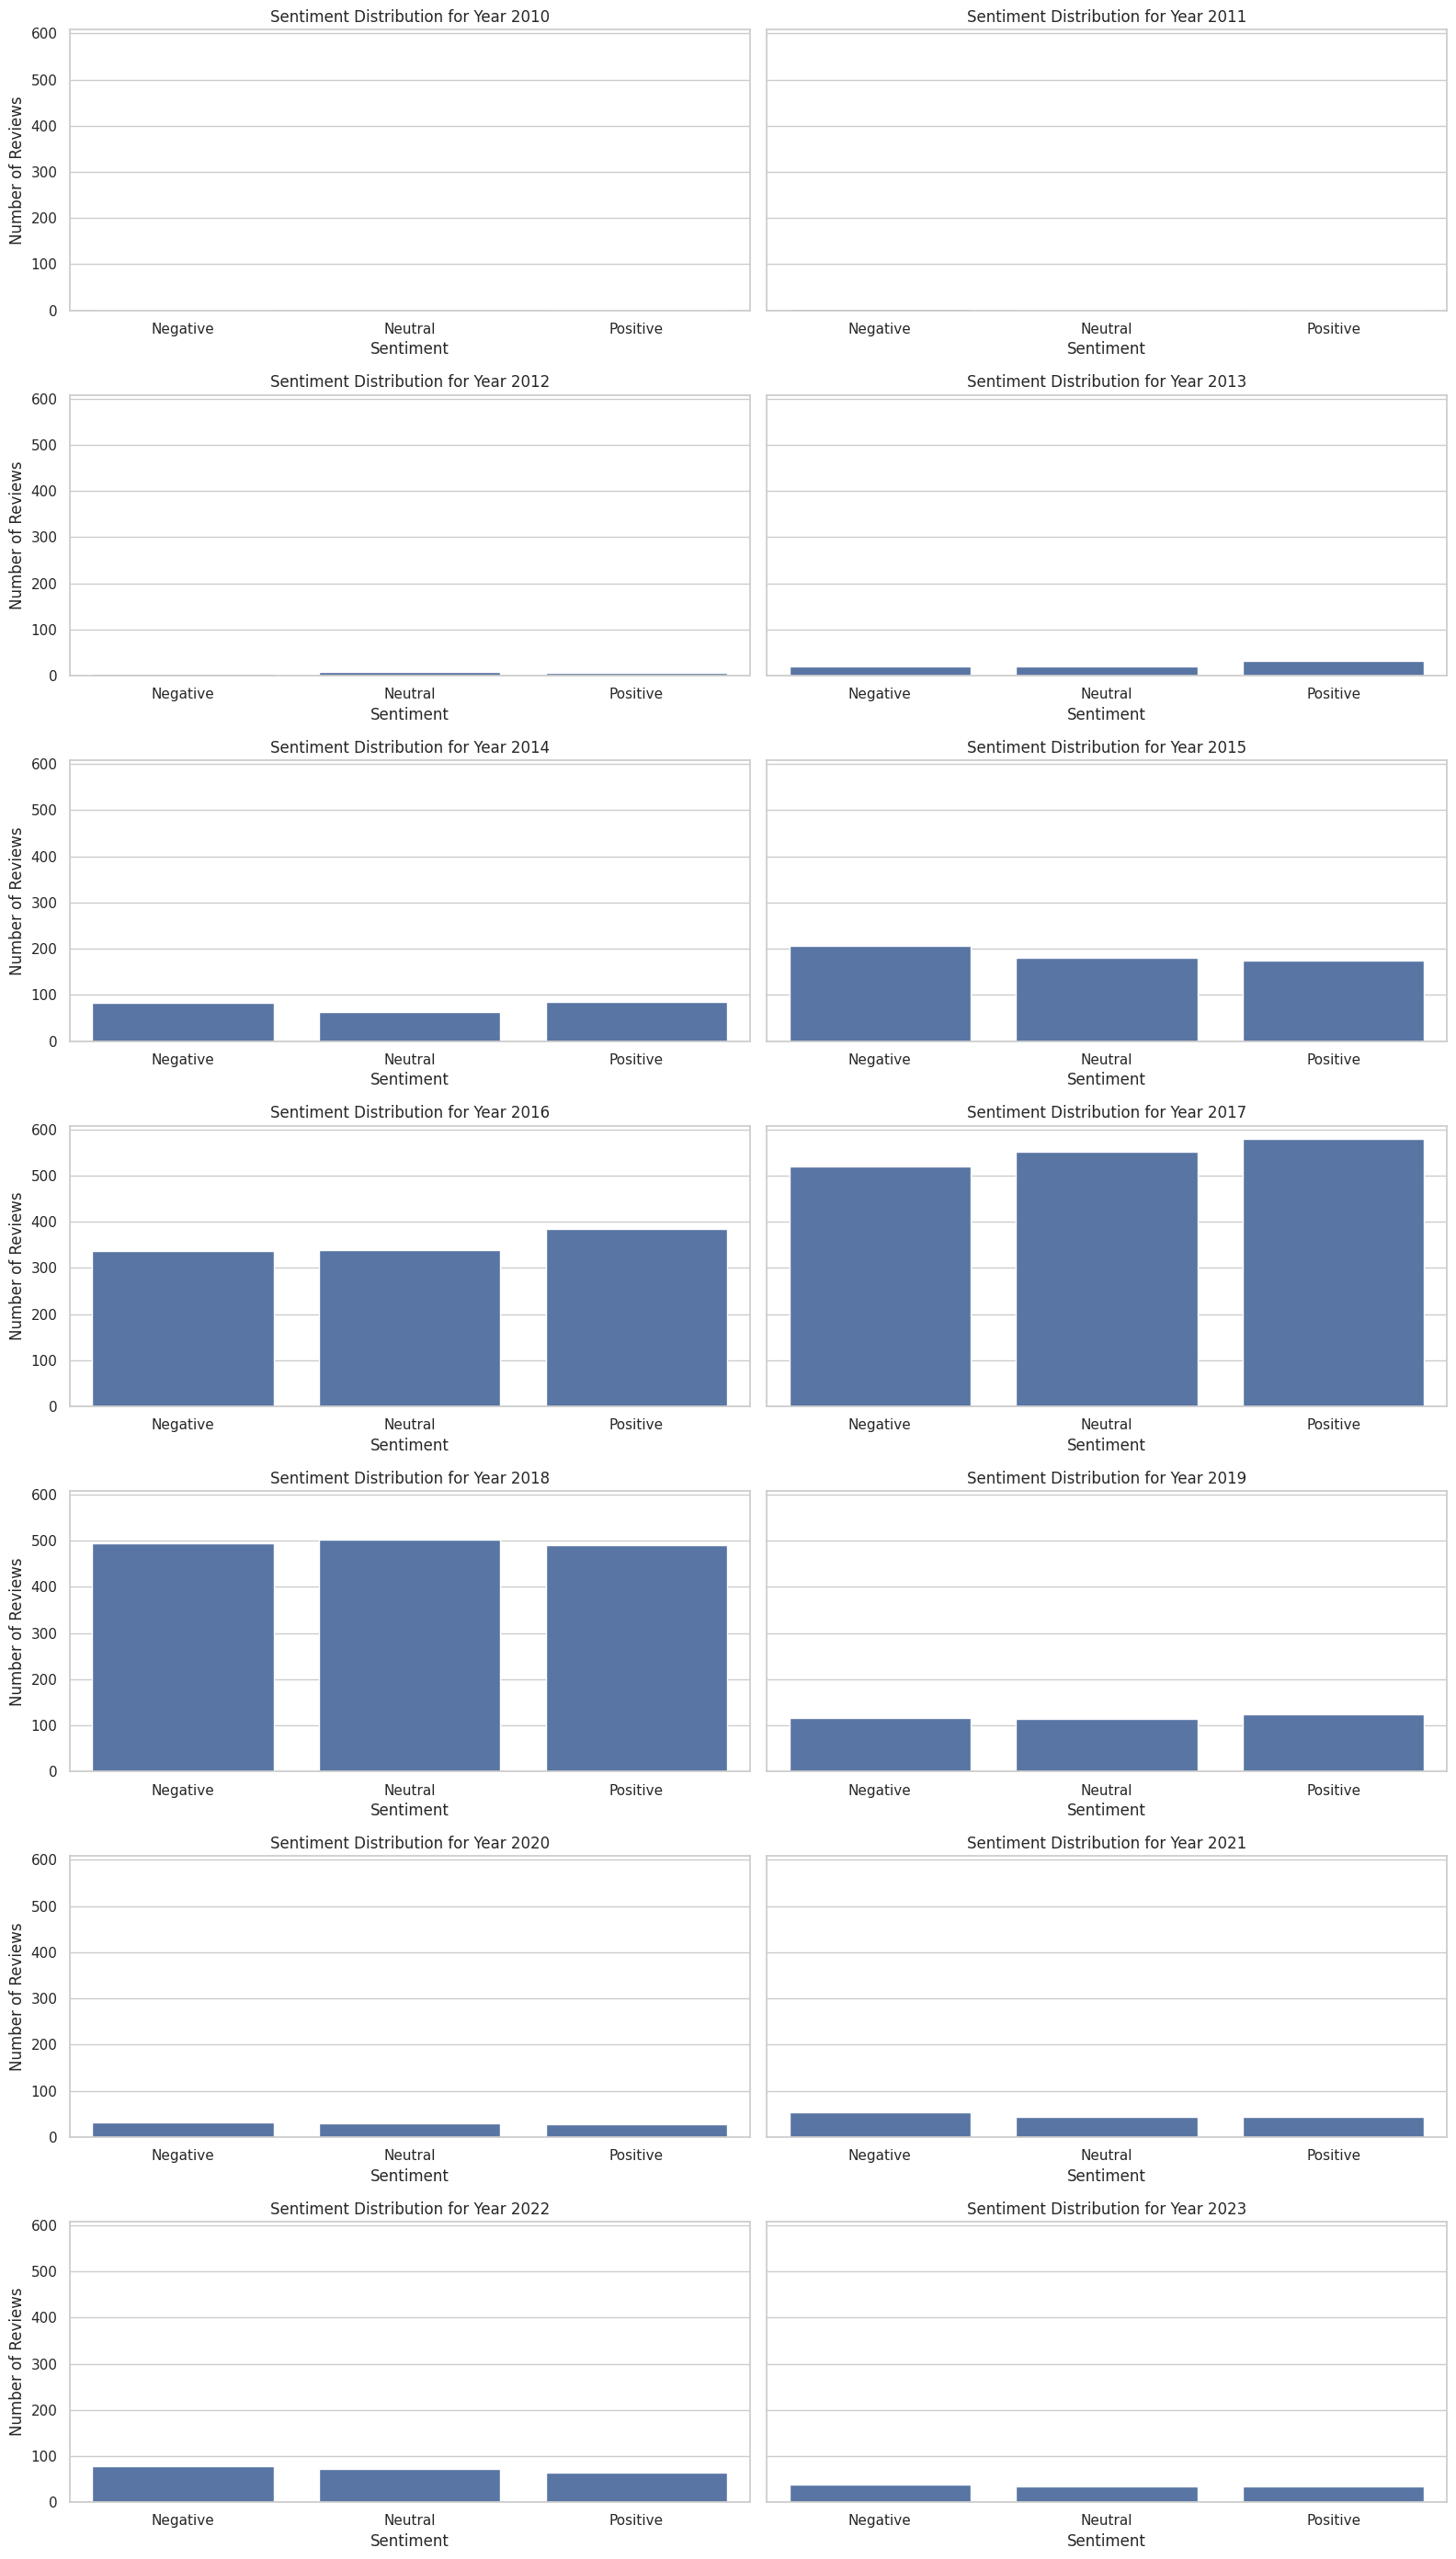

In [ ]:
# extract the year from the date column and create a new column
df_combined['year'] = pd.to_datetime(df_combined['date']).dt.year

# group the data by year and sentiment
grouped = df_combined.groupby(['year', 'sentiment']).size().unstack(fill_value=0)

sns.set(style="whitegrid")

num_years = len(grouped)
cols = 2                        # number of columns in the subplot grid
rows = (num_years + 1) // cols  # number of rows in the subplot grid

# create the figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows), sharey=True)

# flatten the axes array for easy iteration
axes = axes.flatten()

# plot histograms for each year
for i, (year, sentiments) in enumerate(grouped.iterrows()):
    sns.barplot(x=sentiments.index, y=sentiments.values, ax=axes[i])
    axes[i].set_title(f'Sentiment Distribution for Year {year}')
    axes[i].set_xlabel('Sentiment')
    axes[i].set_ylabel('Number of Reviews')

# remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

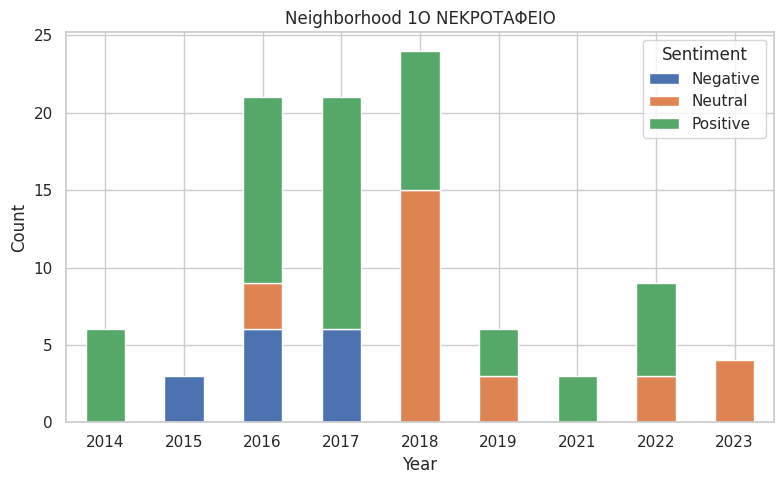

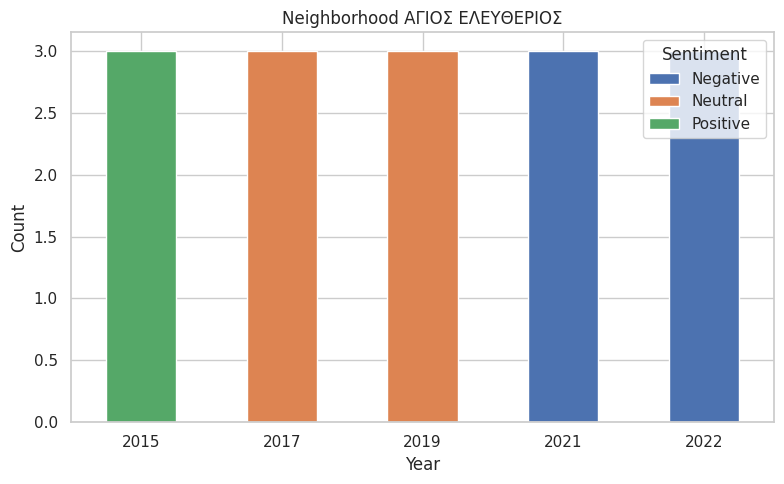

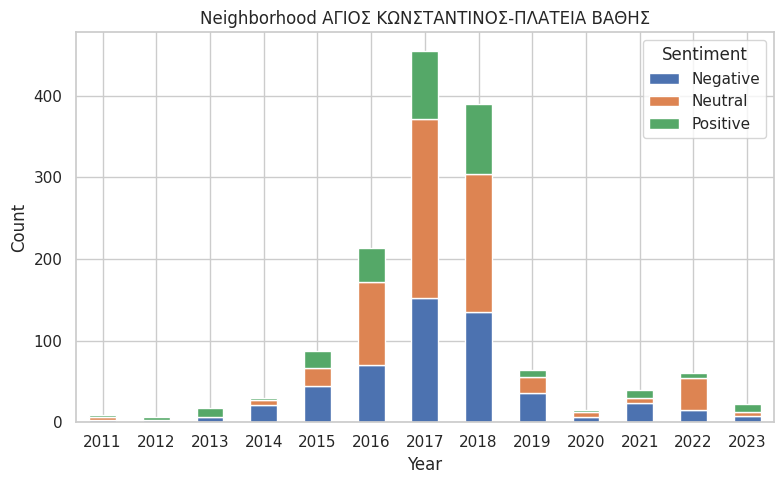

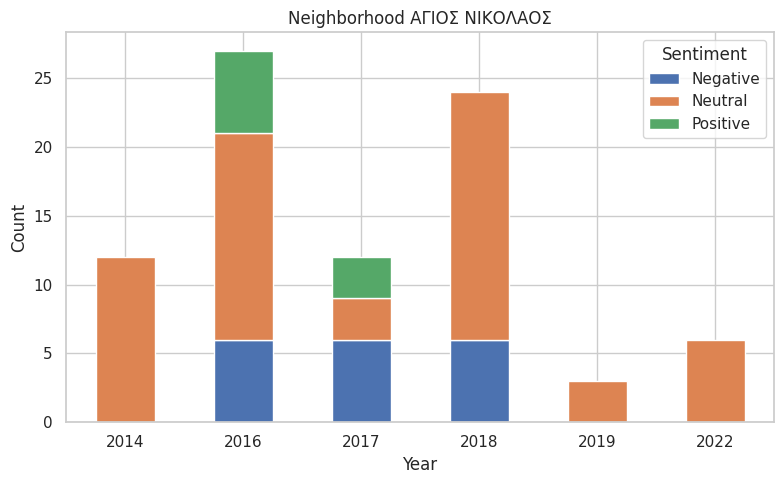

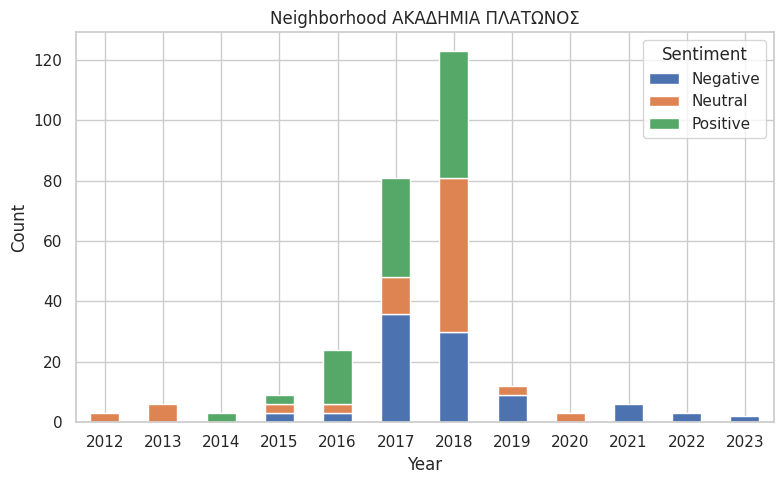

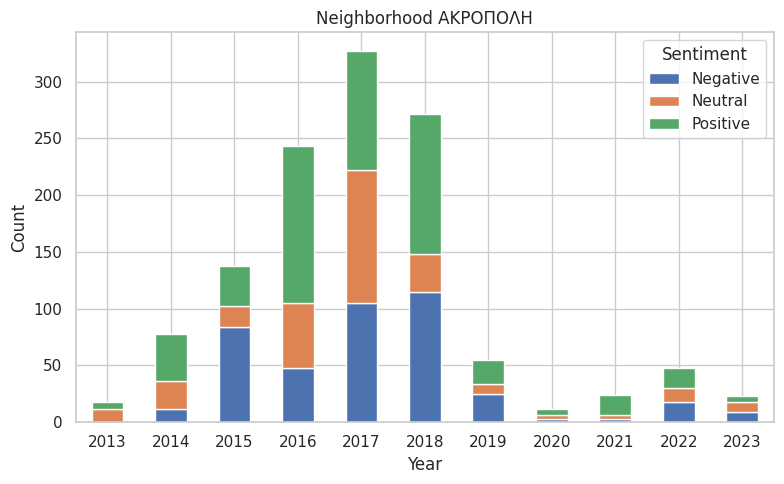

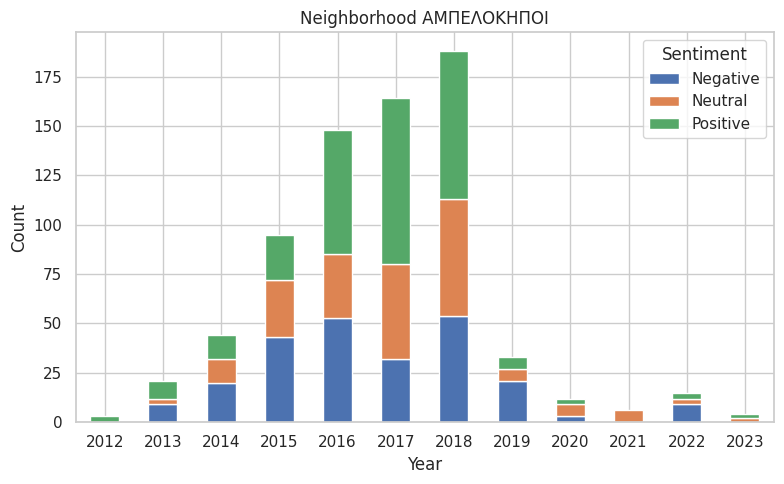

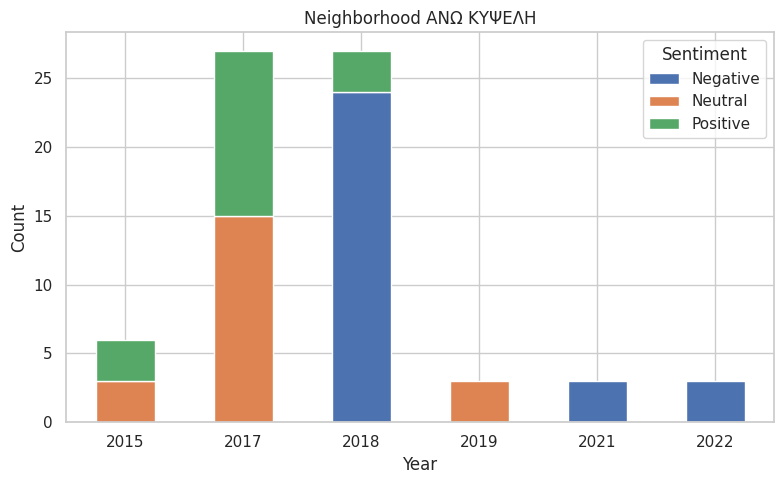

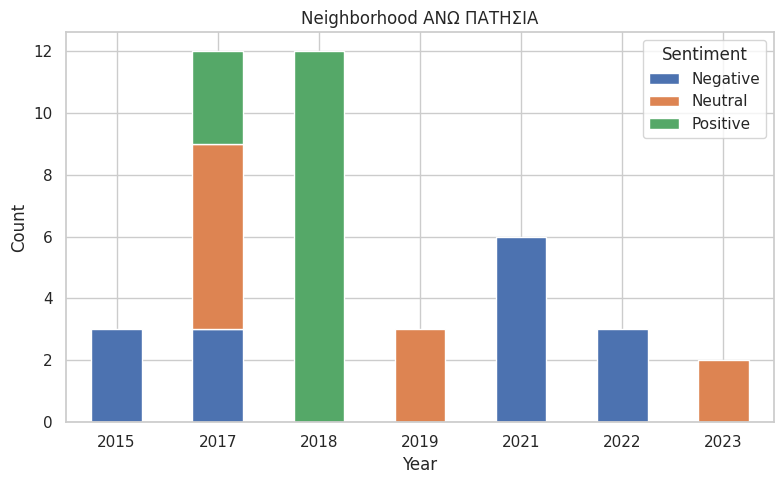

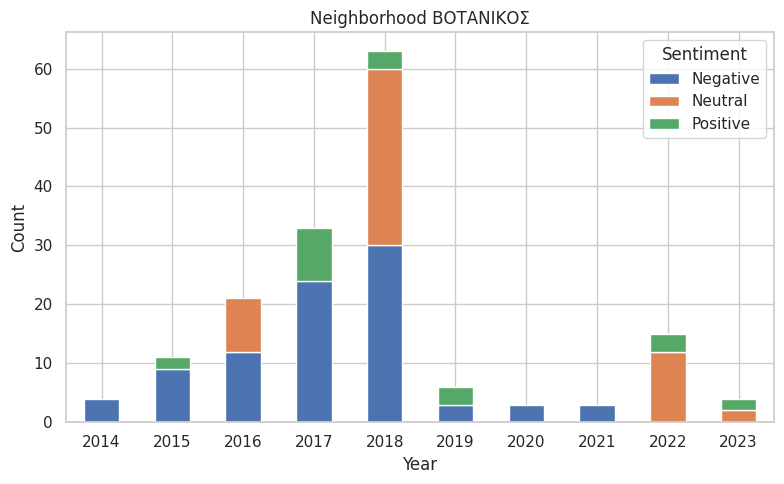

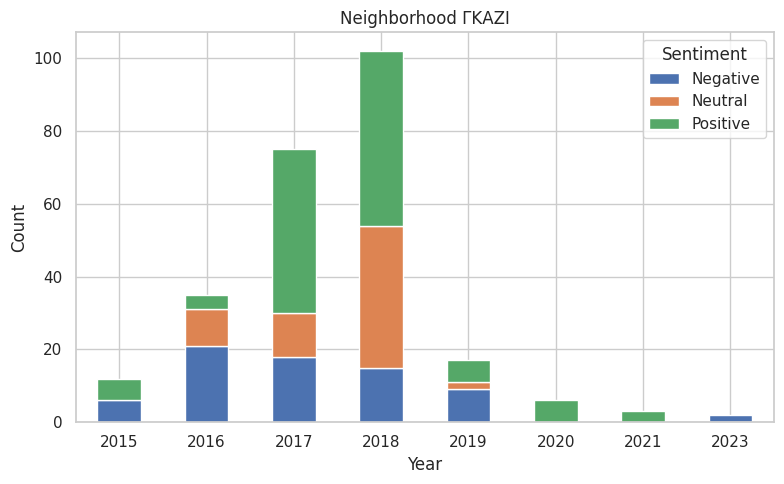

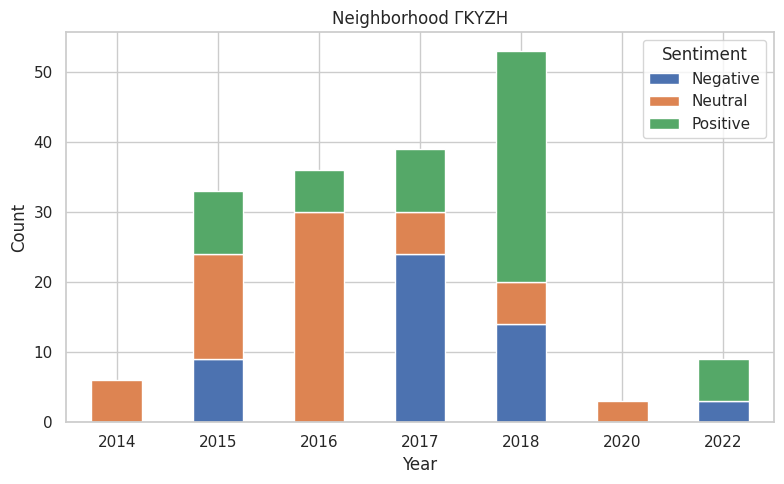

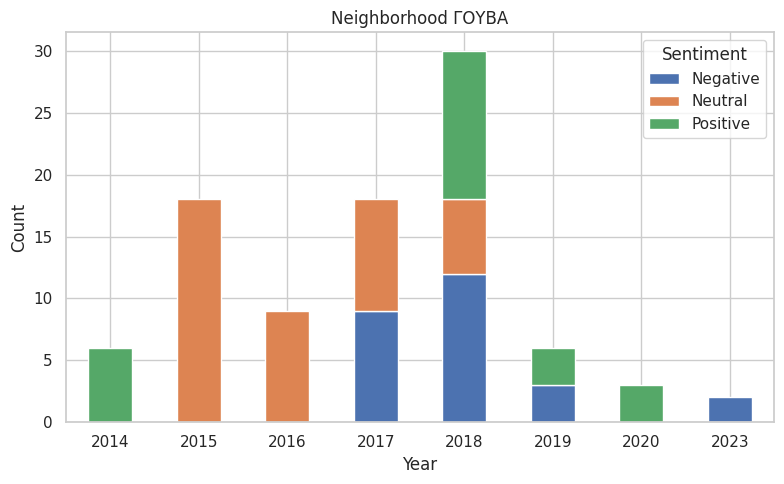

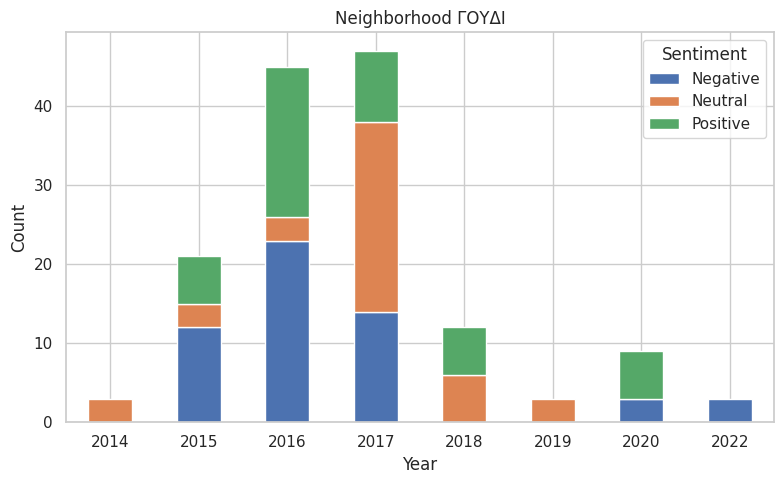

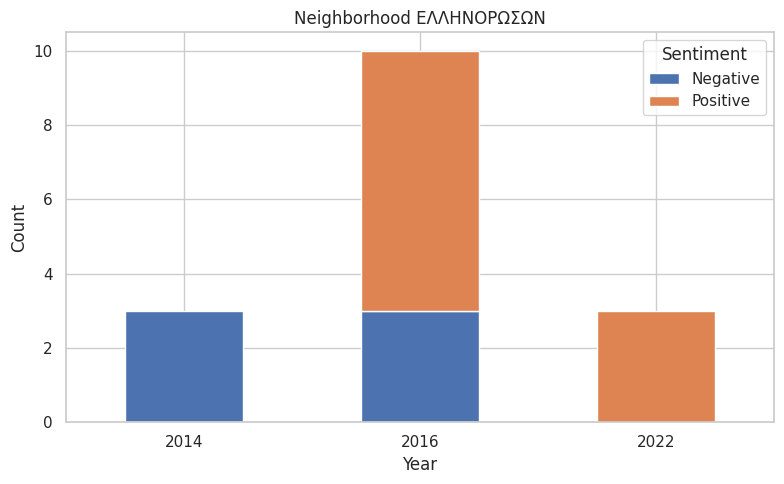

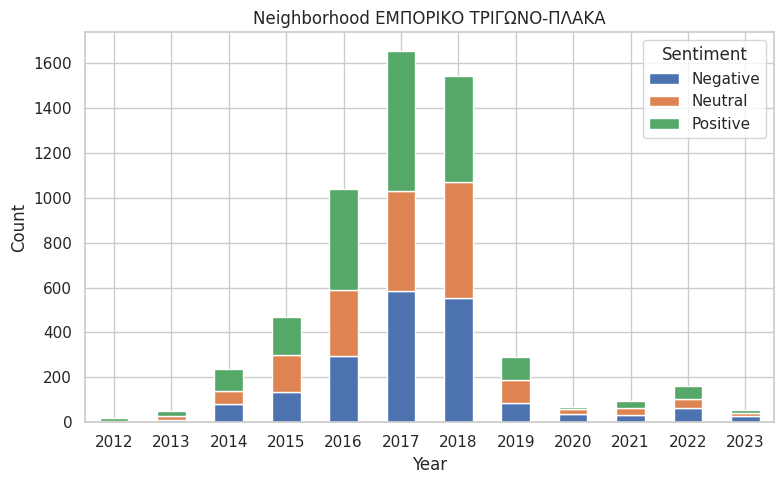

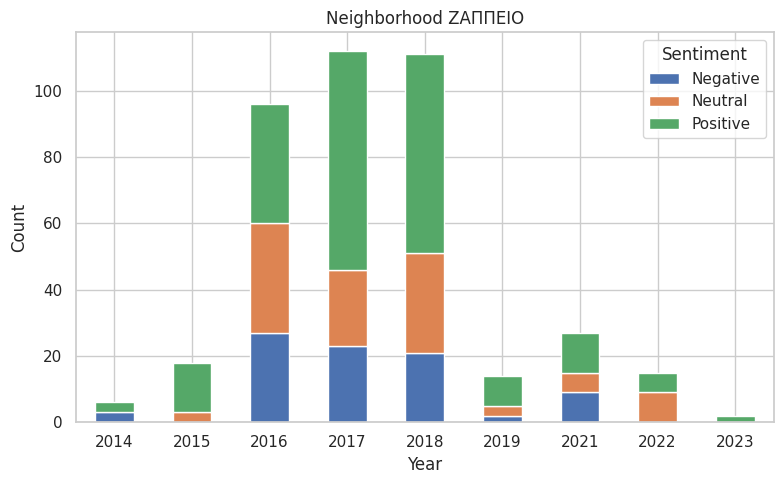

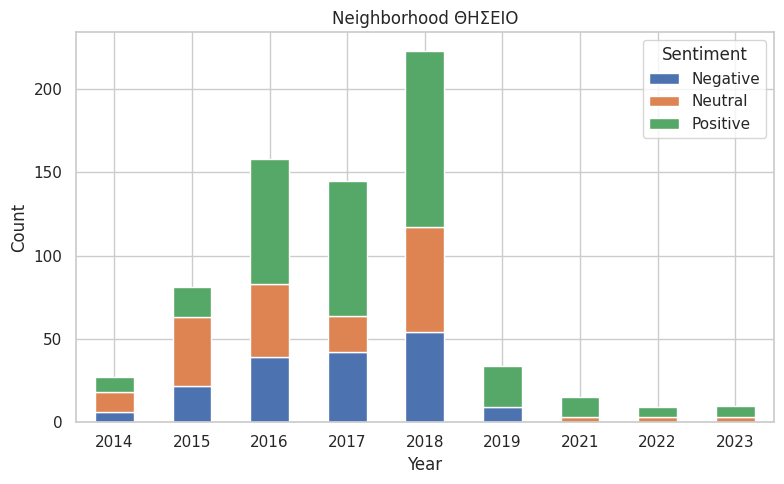

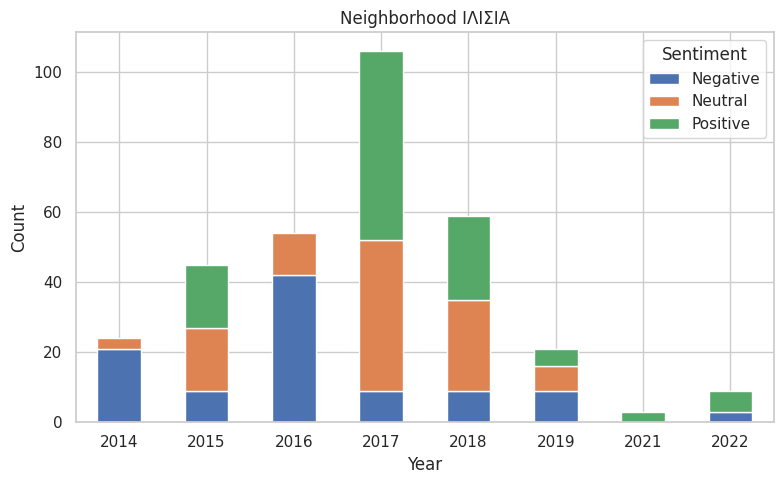

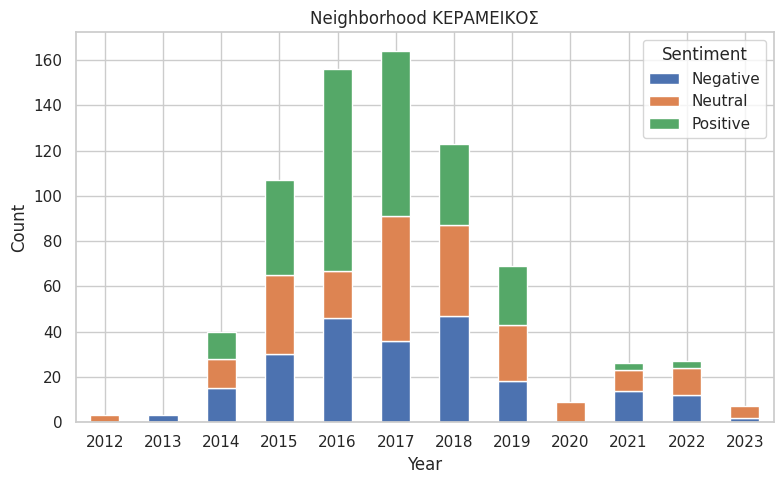

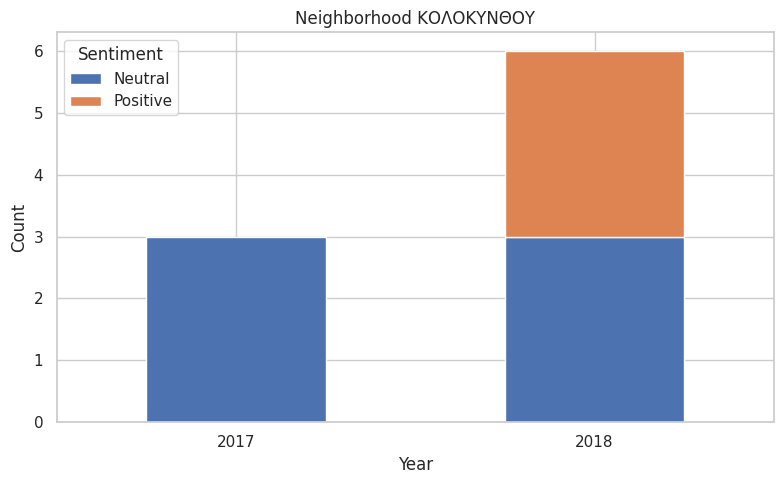

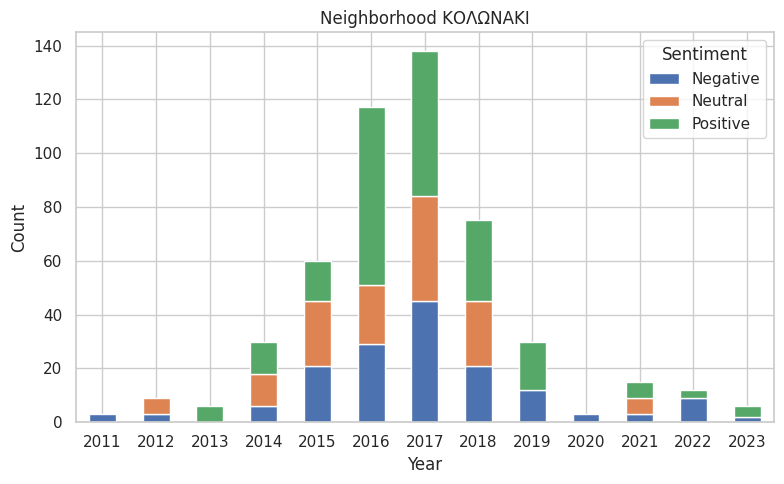

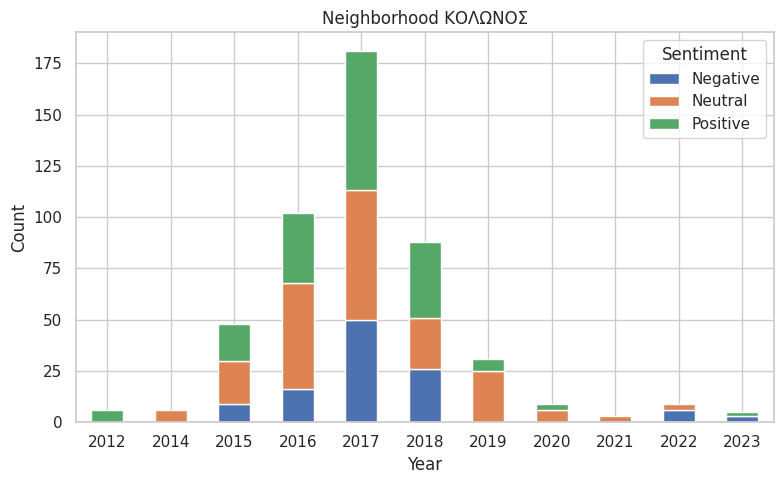

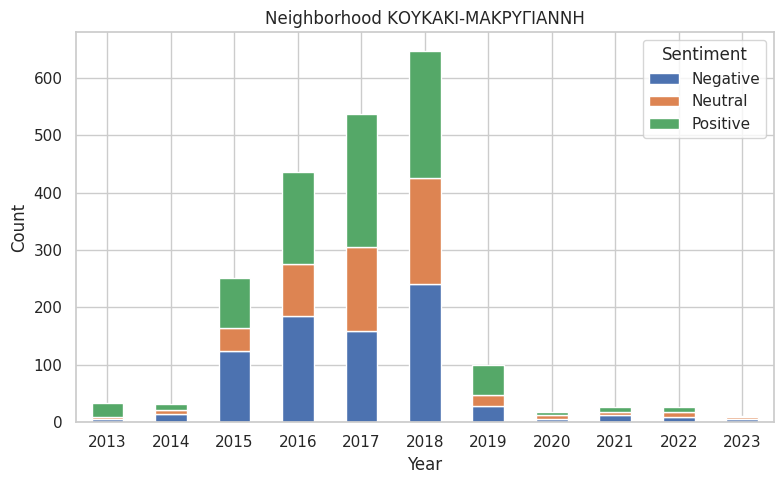

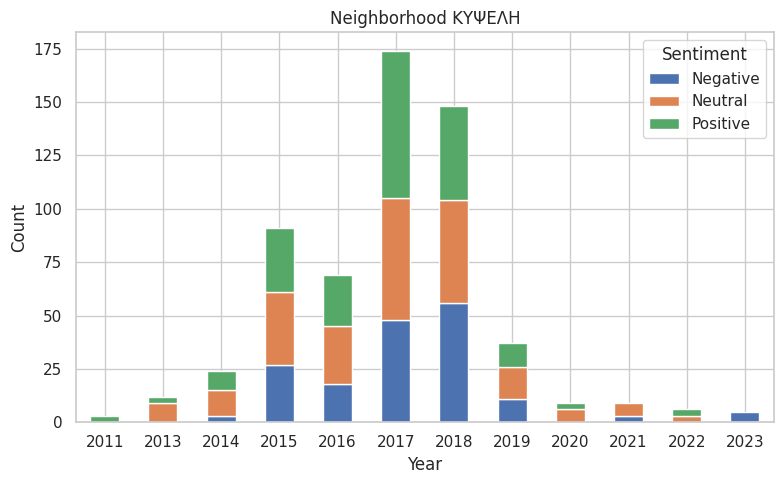

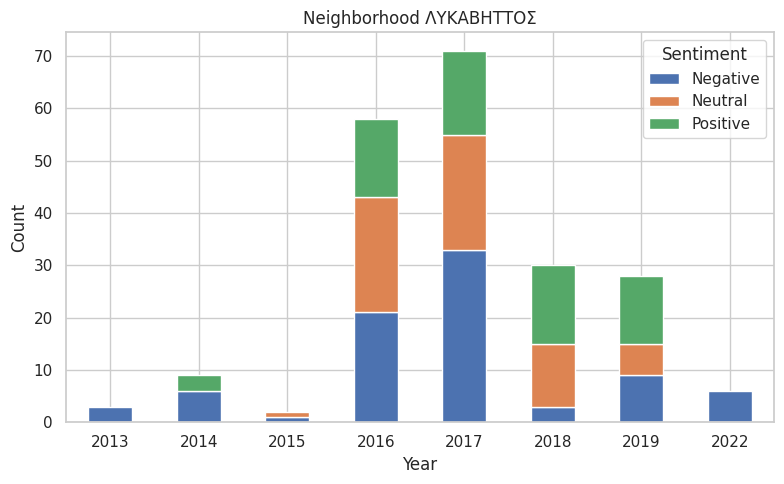

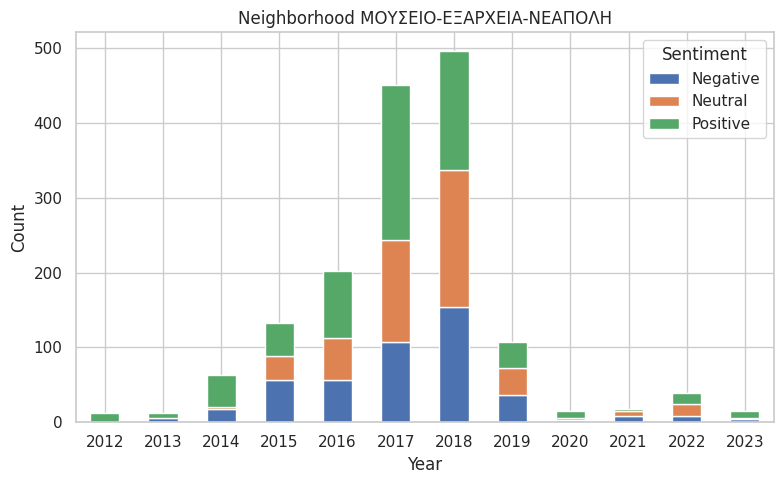

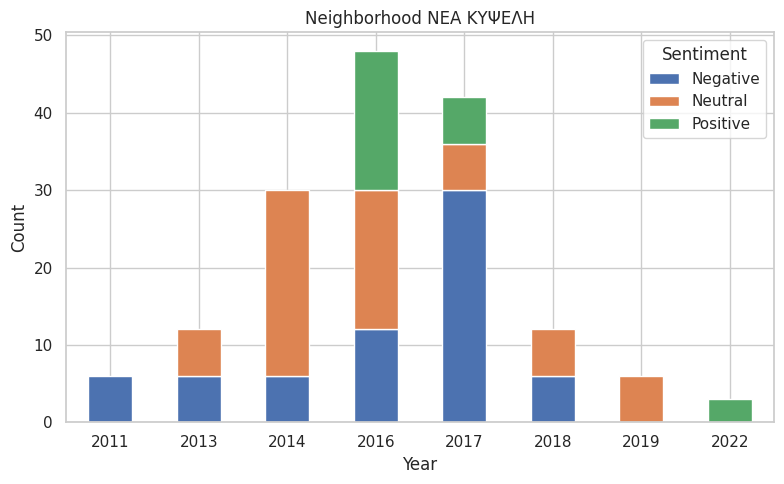

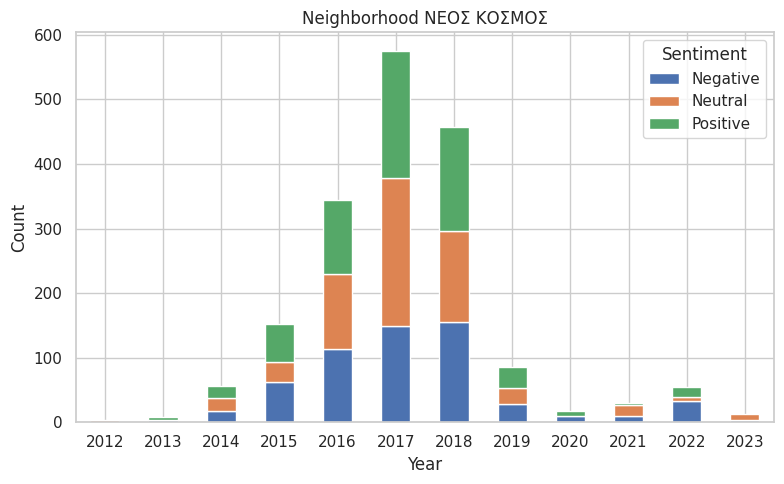

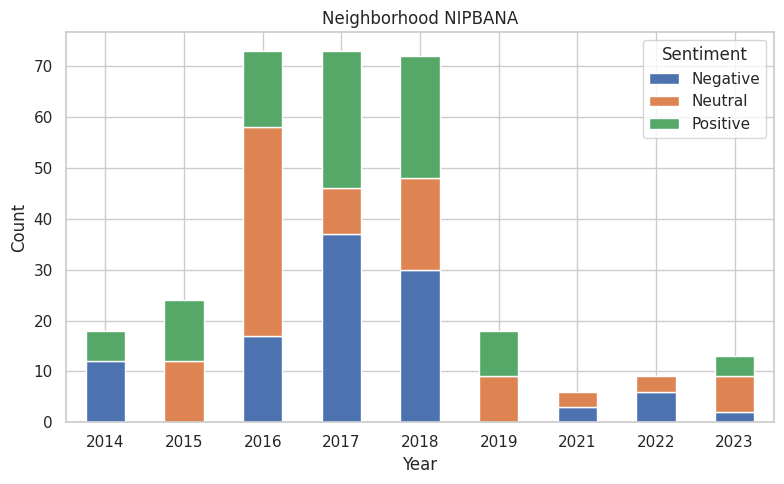

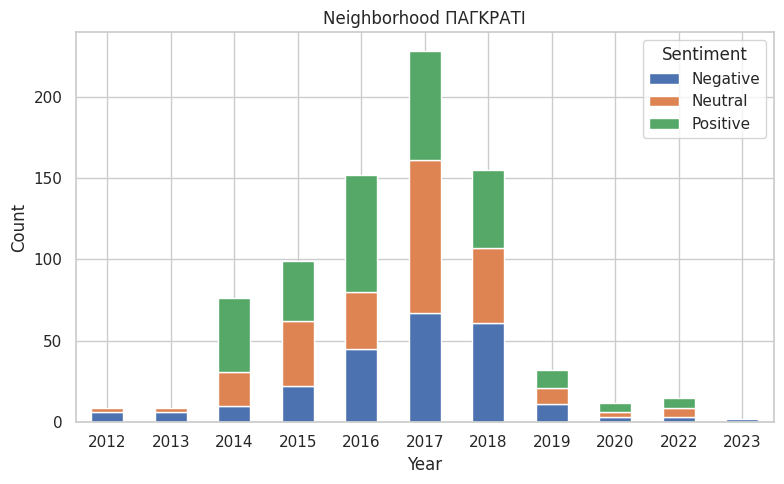

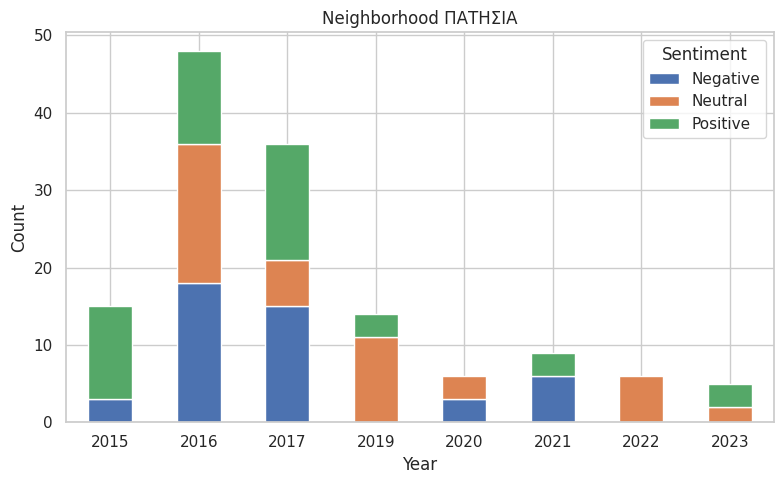

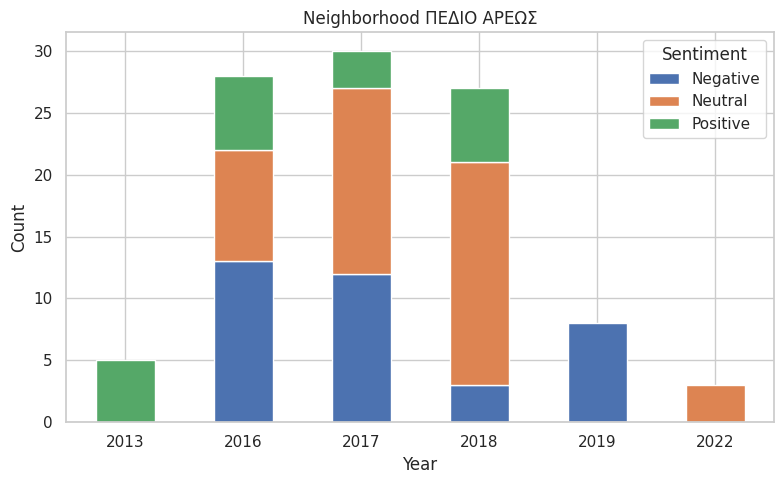

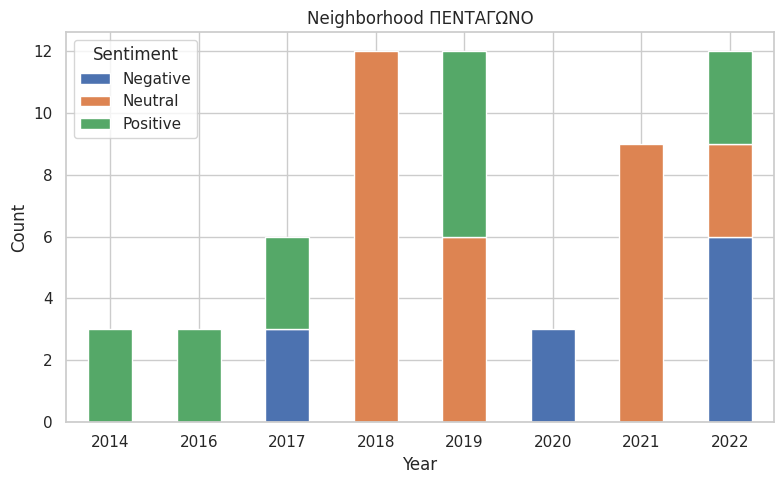

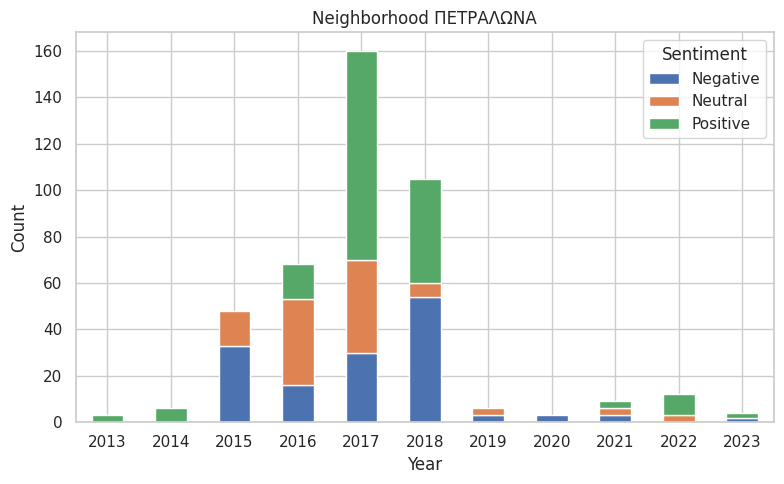

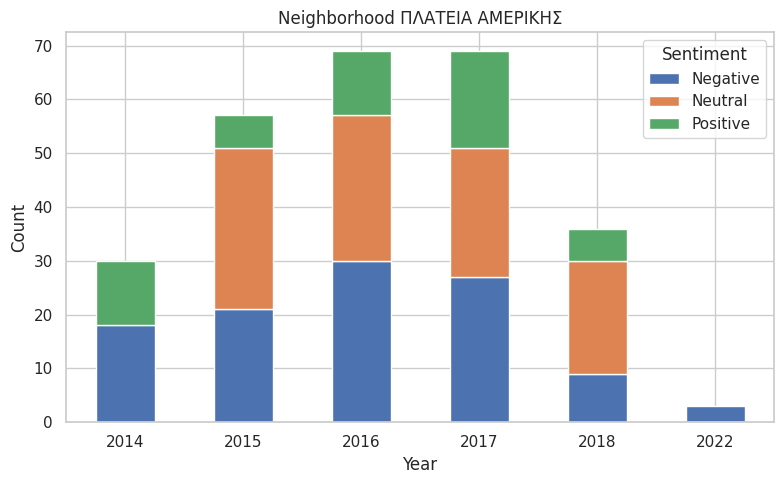

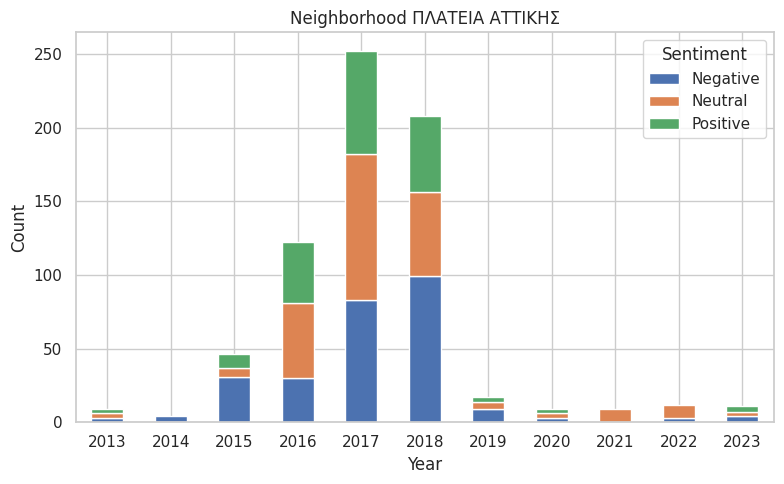

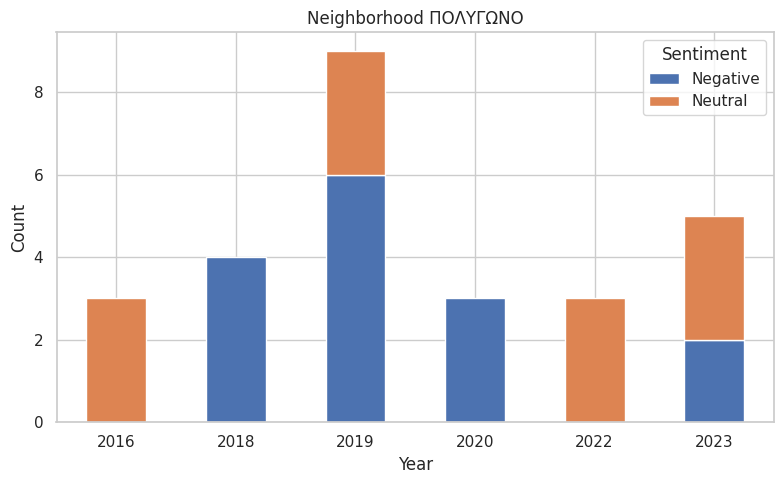

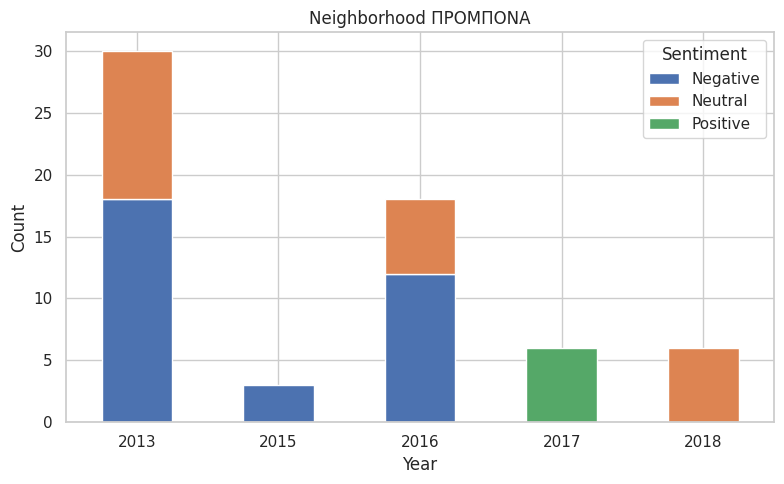

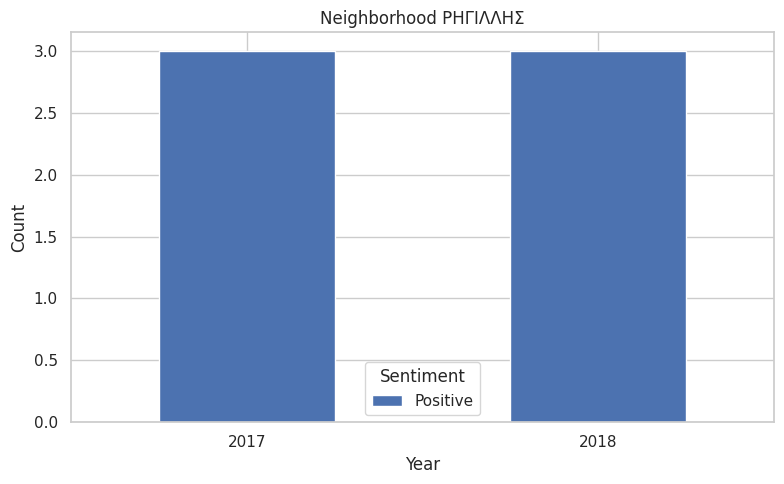

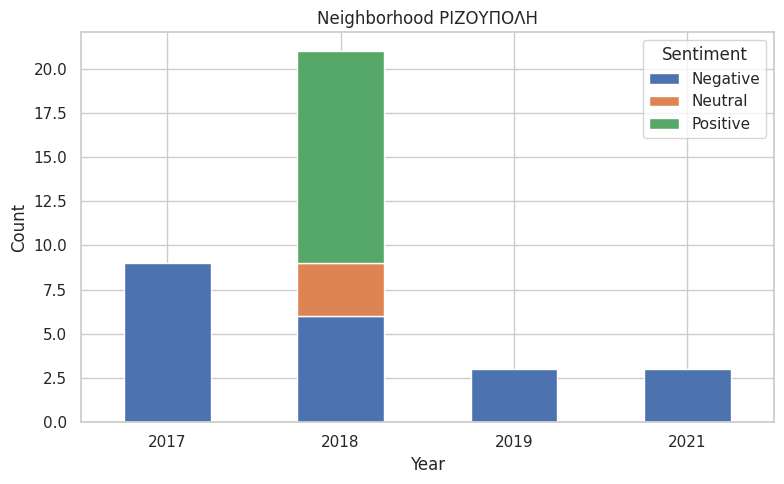

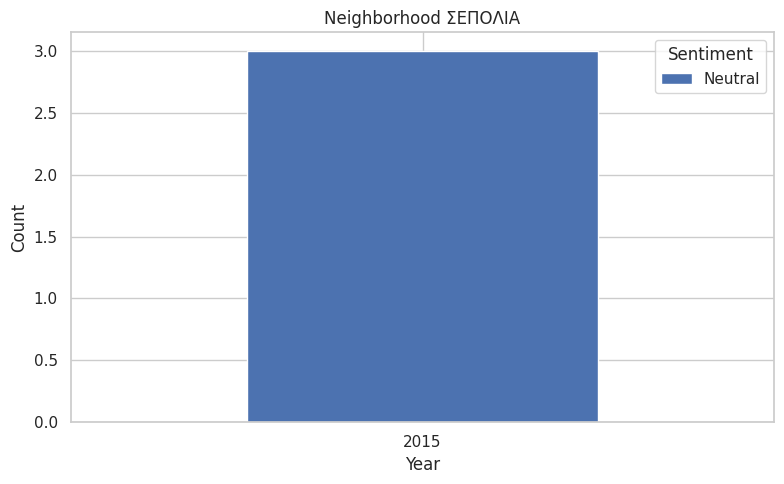

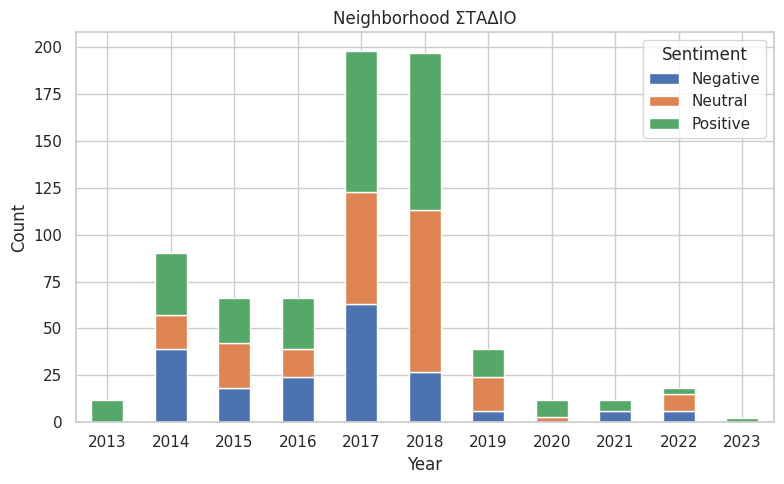

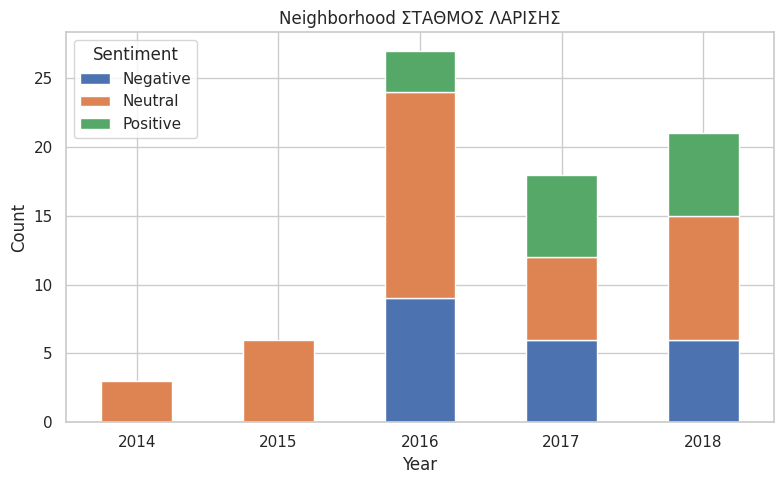

In [ ]:
def add_neighbourhoods(df):
    # combine m2019 and m2023 to get the complete id to neighborhood mapping
    neighborhood_mapping = pd.concat([m2019[['id', 'neighbourhood']], m2023[['id', 'neighbourhood']]], ignore_index=True)

    # Remove duplicates in case there are any
    neighborhood_mapping = neighborhood_mapping.drop_duplicates(subset='id')

    neighborhood_mapping.rename(columns={'id': 'listing_id'}, inplace=True)

    id_mapping = pd.concat([r2019[['listing_id', 'id']], r2023[['id', 'listing_id']]], ignore_index=True)
    neighborhood_mapping = neighborhood_mapping.drop_duplicates(subset='listing_id')

    # Merge the neighborhood mapping with the final_df
    mapping = id_mapping.merge(neighborhood_mapping, on='listing_id', how='left')

    # Drop a column
    mapping.drop(columns=['listing_id'], inplace=True)

    df = df.merge(mapping, on='id', how='left')

    return df

df = add_neighbourhoods(df_combined)

grouped = df.groupby(['neighbourhood', 'year', 'sentiment']).size().reset_index(name='count')
by_neighbourhood = grouped.groupby('neighbourhood')

for neighborhood, rest in by_neighbourhood:
    pivot_table = rest.pivot_table(index='year', columns='sentiment', values='count', fill_value=0)

    pivot_table.plot(kind='bar', stacked=True, figsize=(8, 5))
    plt.title(f'Neighborhood {neighborhood}')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.legend(title='Sentiment')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

### Showcase the dataset

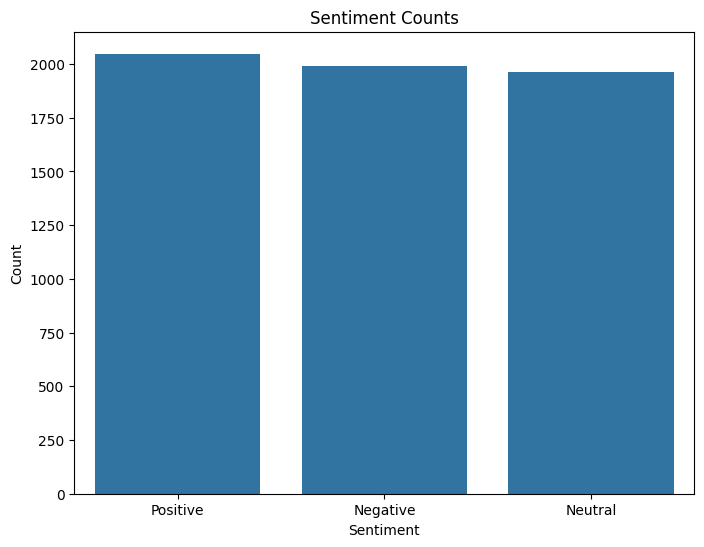

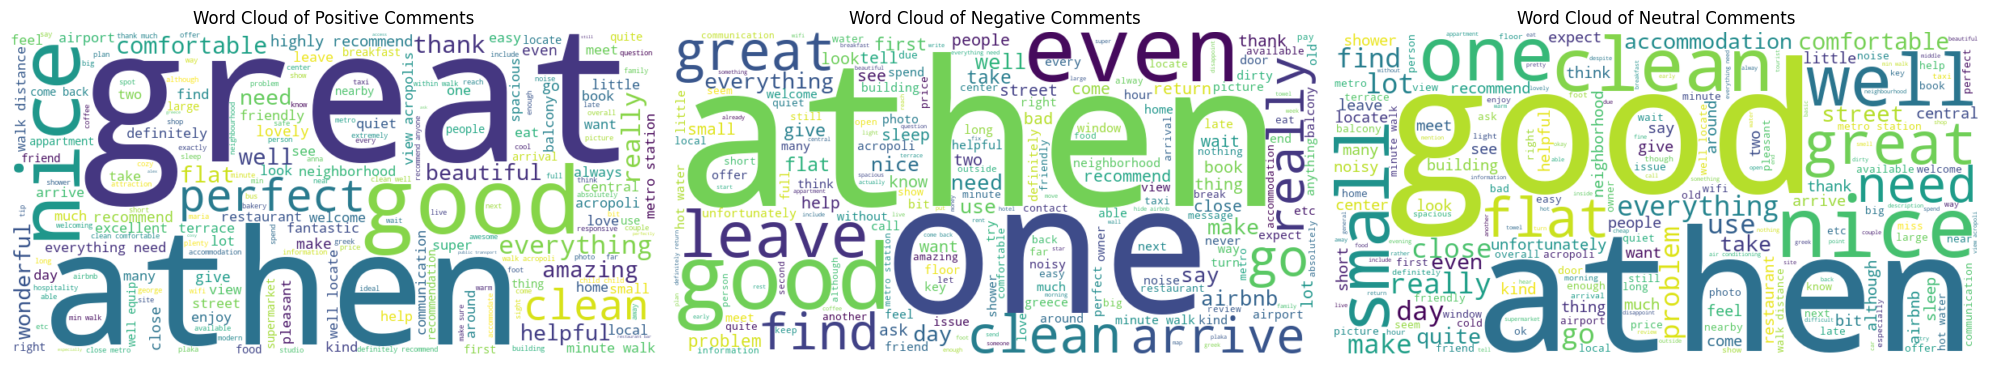

Positive sentiment example:
             id                                 processed_comments sentiment
576   103938298  roula organize well decorate lycabettus hill n...  Positive
961   315637411  wonderful great service simonida ideal young p...  Positive
1725  179962595  day yorgo really nice clean well keep spacious...  Positive
591   113522736  nice alkis appartment super clean modern well ...  Positive
1806  203137276  nikos maria wait show clean comfortable centra...  Positive
Negative sentiment example:
                      id                                 processed_comments  \
2084           204868115  george terrible hospitable door lock sound clo...   
2543           315993929  bad see many people knife chase also bad smell...   
3504           286864605  everything see neighborhood unbeatable unparal...   
3527           136690681  mr christo person good available whenever I re...   
2931  875122457056889478  description metro station taxi stand shop with...   

     se

In [20]:
# here we showcase the dataset
# we only keep id, processed_comment, sentiment
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud

def draw_graphs(df):
    
    plt.figure(figsize=(8, 6))
    sns.countplot(x='sentiment', data=df)
    plt.title('Sentiment Counts')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()

    sentiments = df['sentiment'].unique()
    plt.figure(figsize=(20, 10))
    
    for i, sentiment in enumerate(sentiments, 1):
        text = ' '.join(df[df['sentiment'] == sentiment]['processed_comments'].tolist())
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        
        plt.subplot(1, len(sentiments), i)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud of {sentiment.capitalize()} Comments')
    
    plt.tight_layout()
    plt.show()

    for sentiment in sentiments:
        sentiment_rows = df[df['sentiment'] == sentiment]
        
        sampled_subset = sentiment_rows.sample(n=5)[['id','processed_comments', 'sentiment']]

        print(f"{sentiment} sentiment example:")
        print(sampled_subset)
    
draw_graphs(df_combined)


## **Part 2: Sentiment Analysis**

In [ ]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
result_df = pd.read_csv(dataset_path)

In [ ]:
# separate each sentiment group
positive_df = result_df[result_df['sentiment'] == 'Positive']
negative_df = result_df[result_df['sentiment'] == 'Negative']
neutral_df = result_df[result_df['sentiment'] == 'Neutral']

# split each sentiment group into train and test dataframes
train_positive, test_positive = train_test_split(positive_df, test_size=0.2, random_state=42)
train_negative, test_negative = train_test_split(negative_df, test_size=0.2, random_state=42)
train_neutral, test_neutral = train_test_split(neutral_df, test_size=0.2, random_state=42)

# concatenate the corresponding train and test dataframes
train_df = pd.concat([train_positive, train_negative, train_neutral])
test_df = pd.concat([test_positive, test_negative, test_neutral])

# reset index if needed
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

save = False
if save:
    train_df.to_csv('train_df.csv', index=False)
    test_df.to_csv('test_df.csv', index=False)

We use trained word embeddings from glove.

In [ ]:
download_glove = True
if download_glove:
    !wget https://nlp.stanford.edu/data/glove.6B.zip
    !unzip glove.6B.zip

--2024-06-17 13:38:00--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-06-17 13:38:00--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove.6B.zip.1      100%[===================>] 822.24M  5.03MB/s    in 2m 39s  

2024-06-17 13:40:40 (5.16 MB/s) - ‘glove.6B.zip.1’ saved [862182613/862182613]

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Here, we create the embeddings.

In [ ]:
# calculate TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_train = tfidf_vectorizer.fit_transform(train_df['processed_comments'])
tfidf_test = tfidf_vectorizer.transform(test_df['processed_comments'])

# create a temp folder
os.makedirs("tmp", exist_ok=True)

# save TF-IDF features
with open('./tmp/tfidf_train.pkl', 'wb') as f:
    pickle.dump(tfidf_train, f)

with open('./tmp/tfidf_test.pkl', 'wb') as f:
    pickle.dump(tfidf_test, f)

# save the vectorizer
with open('./tmp/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Load GloVe Embeddings
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# load GloVe embeddings (replace 'glove.6B.100d.txt' with your actual file path)
glove_file_path = 'glove.6B.100d.txt'
word_vectors = load_glove_embeddings(glove_file_path)

def get_average_word2vec(tokens_list, vector, k=100):
    """
    Calculate the average word2vec for each document.
    If a word is not in the vocabulary, it is ignored.
    """

    if len(tokens_list) < 1:
        return np.zeros(k)

    vec = [vector[word] for word in tokens_list if word in vector]
    return np.mean(vec, axis=0) if len(vec) > 0 else np.zeros(k)

# calculate word embeddings for each review
train_embeddings = np.array([get_average_word2vec(comment.split(), word_vectors) for comment in train_df['processed_comments']])
test_embeddings = np.array([get_average_word2vec(comment.split(), word_vectors) for comment in test_df['processed_comments']])

# save Word Embeddings
with open('./tmp/word_embeddings_train.pkl', 'wb') as f:
    pickle.dump(train_embeddings, f)

with open('./tmp/word_embeddings_test.pkl', 'wb') as f:
    pickle.dump(test_embeddings, f)

# save the word vectors (optional, for reference)
with open('./tmp/word_vectors.pkl', 'wb') as f:
    pickle.dump(word_vectors, f)

We are now ready to run sentiment analysis.

In [ ]:
import pandas as pd
import pickle
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# load TF-IDF features
with open('./tmp/tfidf_train.pkl', 'rb') as f:
    tfidf_train = pickle.load(f)

with open('./tmp/tfidf_test.pkl', 'rb') as f:
    tfidf_test = pickle.load(f)

# load word embeddings
with open('./tmp/word_embeddings_train.pkl', 'rb') as f:
    train_embeddings = pickle.load(f)

with open('./tmp/word_embeddings_test.pkl', 'rb') as f:
    test_embeddings = pickle.load(f)

y_train = train_df['sentiment']
y_test = test_df['sentiment']

# define default hyperparameters
default_hyperparameters = {
    'SVM': {'C': 1.0, 'kernel': 'rbf'},
    'RandomForest': {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2},
    'KNN': {'n_neighbors': 5, 'weights': 'uniform'}
}

# function to create classifiers with specified hyperparameters
def create_classifiers(hyperparameters=None):
    if hyperparameters is None:
        hyperparameters = default_hyperparameters

    svm = SVC(**hyperparameters.get('SVM', {}))
    rf = RandomForestClassifier(**hyperparameters.get('RandomForest', {}))
    knn = KNeighborsClassifier(**hyperparameters.get('KNN', {}))

    return {
        'SVM': svm,
        'RandomForest': rf,
        'KNN': knn
    }

# train, predict, and evaluate classifiers
def evaluate_classifier(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # evaluate model
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    return precision, recall, fscore, accuracy

# evaluate classifiers on both TF-IDF and word embeddings
def evaluate_all_classifiers(hyperparameters=None):
    classifiers = create_classifiers(hyperparameters)
    results = []

    for name, clf in classifiers.items():

        # evaluate on TF-IDF
        tfidf_precision, tfidf_recall, tfidf_fscore, tfidf_accuracy = evaluate_classifier(clf, tfidf_train, tfidf_test, y_train, y_test)

        # evaluate on Word Embeddings
        embedding_precision, embedding_recall, embedding_fscore, embedding_accuracy = evaluate_classifier(clf, train_embeddings, test_embeddings, y_train, y_test)

        # store results
        results.append((name, 'TF-IDF', tfidf_precision, tfidf_recall, tfidf_fscore, tfidf_accuracy))
        results.append((name, 'Word Embeddings', embedding_precision, embedding_recall, embedding_fscore, embedding_accuracy))

    results_df = pd.DataFrame(results, columns=['Classifier', 'Feature', 'Precision', 'Recall', 'F-Measure', 'Accuracy'])
    return results_df

# hyperparameters
custom_hyperparameters = {
    'SVM': {'C': 0.5, 'kernel': 'linear'},
    'RandomForest': {'n_estimators': 200, 'max_depth': 10},
    'KNN': {'n_neighbors': 3, 'weights': 'distance'}
}

In [ ]:
results_df = evaluate_all_classifiers()
print("Default hyperparamters:")
print(results_df)

results_df = evaluate_all_classifiers(custom_hyperparameters)
print("\nCustom hyperparamters:")
print(results_df)

Default hyperparamters:
     Classifier          Feature  Precision    Recall  F-Measure  Accuracy
0           SVM           TF-IDF   0.747071  0.744380   0.745102  0.744380
1           SVM  Word Embeddings   0.686670  0.687760   0.686627  0.687760
2  RandomForest           TF-IDF   0.703995  0.706078   0.703388  0.706078
3  RandomForest  Word Embeddings   0.662616  0.665279   0.663365  0.665279
4           KNN           TF-IDF   0.665773  0.348876   0.189742  0.348876
5           KNN  Word Embeddings   0.562520  0.548709   0.546350  0.548709

Custom hyperparamters:
     Classifier          Feature  Precision    Recall  F-Measure  Accuracy
0           SVM           TF-IDF   0.740408  0.736886   0.736897  0.736886
1           SVM  Word Embeddings   0.674213  0.675271   0.674491  0.675271
2  RandomForest           TF-IDF   0.662399  0.666112   0.660807  0.666112
3  RandomForest  Word Embeddings   0.658474  0.661948   0.658590  0.661948
4           KNN           TF-IDF   0.724226  0.39966

# Results 

- SVM: Performed consistently with both Features and hyperparameters giving the best performance out of all classifiers reaching an F-measure of 0.745
- Random Forest: Performed similarly to SVM with slightly lower scores.
- KNN: Performed poorly compared to the other models with low recall and accuracy but high precision which possibly means that the model is biased towards some classes

We observe that TF-IDF outperforms Word embeddings in both SVM and Random forest but fails to do so in KNN. 

Some possible improvements are further exploring different hyperparameters possibly by using a hyperparameter optimization framework like optuna.